In [1]:
import torch
import torchvision
from torchvision import transforms
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [2]:
from torchvision import datasets

# Load the MNIST dataset without normalization
train_dataset = datasets.MNIST(root='./data', train=True, download=True)

# Calculate mean and std across the dataset
data = train_dataset.data/ 255.  # Scale pixel values to [0, 1]
mean = torch.mean(data)
std= torch.std(data)

print("Mean:", mean)
print("Std Deviation:", std)


100%|██████████| 9912422/9912422 [00:00<00:00, 70317970.89it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 56499857.19it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 30785594.27it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 13257152.94it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Mean: tensor(0.1307)
Std Deviation: tensor(0.3081)


In [3]:
import numpy as np
from torchvision import datasets

# Load the MNIST dataset without normalization
test_dataset = datasets.MNIST(root='./data', train=False, download=True)

# Calculate mean and std across the dataset
data = test_dataset.data/ 255.  # Scale pixel values to [0, 1]
mean = torch.mean(data)
std= torch.std(data)

print("Mean:", mean)
print("Std Deviation:", std)


Mean: tensor(0.1325)
Std Deviation: tensor(0.3105)


In [4]:
train_transforms = transforms.Compose([
                                    transforms.ToTensor(),  # Convert numpy array to tensor
                                    transforms.Normalize(0.1307, 0.3081)])

val_transforms = transforms.Compose([
                                    transforms.ToTensor(),  # Convert numpy array to tensor
                                    transforms.Normalize(0.1325, 0.3105)])

In [5]:
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=train_transforms)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=val_transforms)

In [6]:
# Create data loaders
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, )
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, )
print(f"There are {len(train_dataset)} train images and {len(test_dataset)} val images")


There are 60000 train images and 10000 val images


In [7]:
# Create a neural net class
class Net(nn.Module):
    # Constructor
    def __init__(self, num_classes=10):
        super(Net, self).__init__()

        # Our images are grayscale, so input channels = 1. We'll apply 12 filters in the first convolutional layer
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=12, kernel_size=3, stride=1, padding=1)

        # We'll apply max pooling with a kernel size of 2
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        # A second convolutional layer takes 12 input channels, and generates 24 outputs
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=1)

        # We'll apply another max pooling with a kernel size of 2
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        # A drop layer deletes 20% of the features to help prevent overfitting
        self.drop = nn.Dropout2d(p=0.2)

        # Our 28x28 image tensors will be pooled twice with a kernel size of 2. 28/2/2 is 7.
        # So our feature tensors are now 7 x 7, and we've generated 24 of them
        # We need to flatten these and feed them to a fully-connected layer
        # to map them to  the probability for each class
        self.fc = nn.Linear(in_features=7 * 7 * 24, out_features=num_classes)

    def forward(self, x):
        # Use a relu activation function after layer 1 (convolution 1 and pool)
        x = F.relu(self.pool1(self.conv1(x)))

        # Use a relu activation function after layer 2 (convolution 2 and pool)
        x = F.relu(self.pool2(self.conv2(x)))

        # Select some features to drop after the 2nd convolution to prevent overfitting
        x = self.drop(x)

        # Flatten
        x = x.view(-1, 7 * 7 * 24)
        # Feed to fully-connected layer to predict class
        x = self.fc(x)
        # Return log_softmax tensor
        return F.log_softmax(x, dim=1)
# Instantiate the model
model = Net()
print("CNN model class defined!")

CNN model class defined!


In [8]:
def train(model, device, train_loader, optimizer, epoch):
    # Set the model to training mode
    model.train()
    train_loss = 0
    print("Epoch:", epoch)
    # Process the images in batches
    for batch_idx, (data, target) in enumerate(train_loader):
        # Use the CPU or GPU as appropriate
        data, target = data.to(device), target.to(device)

        # Reset the optimizer
        optimizer.zero_grad()

        # Push the data forward through the model layers
        output = model(data)

        # Get the loss
        loss = loss_criteria(output, target)

        # Keep a running total
        train_loss += loss.item()

        # Backpropagate
        loss.backward()
        optimizer.step()

        # Print metrics for every 10 batches so we see some progress
        if batch_idx % 10 == 0:
            print(f'Training set:{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader)} Loss:{loss.item()})')
    # return average loss for the epoch
    avg_loss = train_loss / (batch_idx+1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss

In [9]:
def test(model, device, test_loader):
    # Switch the model to evaluation mode (so we don't backpropagate or drop)
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        batch_count = 0
        for data, target in test_loader:
            batch_count += 1
            data, target = data.to(device), target.to(device)

            # Get the predicted classes for this batch
            output = model(data)

            # Calculate the loss for this batch
            test_loss += loss_criteria(output, target).item()

            # Calculate the accuracy for this batch
            _, predicted = torch.max(output.data, 1)
            correct += torch.sum(target==predicted).item()

    # Calculate the average loss and total accuracy for this epoch
    avg_loss = test_loss/batch_count
    print(f'Validation set: Average loss: {avg_loss}, Accuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset)}%)')
   # return average loss for the epoch
    return avg_loss

In [10]:
device = "cpu"
if (torch.cuda.is_available()):
    # if GPU available, use cuda (on a cpu, training will take a considerable length of time!)
    device = "cuda"
print('Training on', device)

# Create an instance of the model class and allocate it to the device
model = Net(num_classes=10).to(device)

# Use an "Adam" optimizer to adjust weights
# (see https://pytorch.org/docs/stable/optim.html#algorithms for details of supported algorithms)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Specify the loss criteria
loss_criteria = nn.CrossEntropyLoss()

# Track metrics in these arrays
epoch_nums = []
training_loss = []
validation_loss = []

# Train over  epochs
epochs = 10
for epoch in range(1, epochs + 1):
        train_loss = train(model, device, train_loader, optimizer, epoch)
        test_loss = test(model, device, test_loader)
        epoch_nums.append(epoch)
        training_loss.append(train_loss)
        validation_loss.append(test_loss)

Training on cpu
Epoch: 1
Training set:0/60000 (0.0 Loss:2.2701799869537354)
Training set:640/60000 (1.0660980810234542 Loss:1.8037726879119873)
Training set:1280/60000 (2.1321961620469083 Loss:1.2262235879898071)
Training set:1920/60000 (3.1982942430703623 Loss:0.6244477033615112)
Training set:2560/60000 (4.264392324093817 Loss:0.6459503769874573)
Training set:3200/60000 (5.330490405117271 Loss:0.4323614239692688)
Training set:3840/60000 (6.3965884861407245 Loss:0.24499382078647614)
Training set:4480/60000 (7.462686567164179 Loss:0.5230390429496765)
Training set:5120/60000 (8.528784648187633 Loss:0.4717857837677002)
Training set:5760/60000 (9.594882729211088 Loss:0.3159511089324951)
Training set:6400/60000 (10.660980810234541 Loss:0.23602613806724548)
Training set:7040/60000 (11.727078891257996 Loss:0.476959764957428)
Training set:7680/60000 (12.793176972281449 Loss:0.2517552971839905)
Training set:8320/60000 (13.859275053304904 Loss:0.38248223066329956)
Training set:8960/60000 (14.925

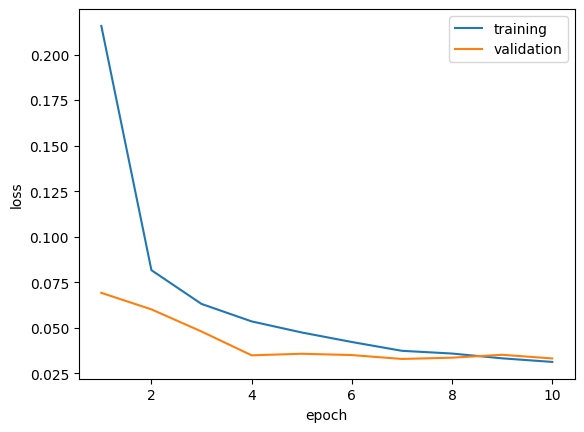

In [11]:
from matplotlib import pyplot as plt

plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

Getting predictions from test set...


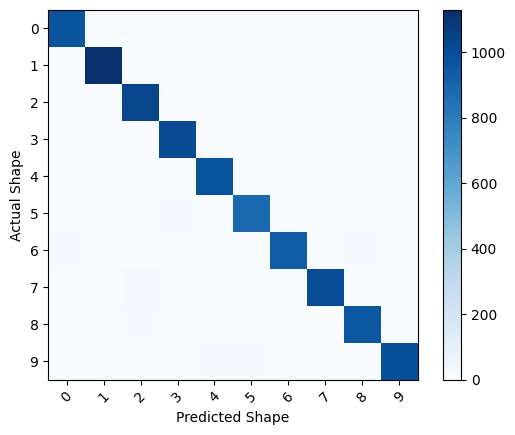

In [12]:
from sklearn.metrics import confusion_matrix
classes=[0,1,2,3,4,5,6,7,8,9]

# Set the model to evaluate mode
model.eval()

# Get predictions for the test data and convert to numpy arrays for use with SciKit-Learn
print("Getting predictions from test set...")
truelabels = []
predictions = []
for data, target in test_loader:
    for label in target.cpu().data.numpy():
        truelabels.append(label)
    for prediction in model.cpu()(data).data.numpy().argmax(1):
        predictions.append(prediction)

# Plot the confusion matrix
cm = confusion_matrix(truelabels, predictions)
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(10)
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel("Predicted Shape")
plt.ylabel("Actual Shape")
plt.show()


In [13]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 14506
